In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import keras
from keras.layers import Dense, Input
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import models, layers
import random
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

#Load & Preprocessing

In [64]:
dataInputPath = '/content/drive/MyDrive/final'
paper_imagePathInput = os.path.join(dataInputPath, 'paper/')
rock_imagePathInput = os.path.join(dataInputPath, 'rock/')
scissors_imagePathInput = os.path.join(dataInputPath, 'scissors/')

load the images and the corresponding labels in lists

In [65]:

file_list = os.listdir(dataInputPath) # Get the list of files in the directory
image_list = []
label_array = []
for i, file in enumerate(file_list):
  imagePathInput = os.path.join(dataInputPath, file)
  print(file)
  image_files = os.listdir(imagePathInput)
  label_array += [i] * len(image_files)
  for image_file in image_files:
    image_path = os.path.join(imagePathInput, image_file)
    image = Image.open(image_path)


    # Define the target dimensions while maintaining the same aspect ratio
    target_width = 32  # Replace with your desired width / original image shape: (200, 300, 3)
    target_height = int(image.height * (target_width / image.width))

    # Resize the image
    resized_image = image.resize((target_width, target_height), Image.BILINEAR)

    np_img = np.array(resized_image)
    grayscale_image = np.mean(np_img, axis=-1, keepdims=True)
    image_list.append(grayscale_image)


rock
scissors
paper


Shuffle the combined data:

In [66]:
# Use zip to combine the two lists into pairs
combined_data = list(zip(image_list, label_array))

# Shuffle the combined data
random.shuffle(combined_data)

# Use zip again to separate the shuffled pairs back into two lists
image_list, label_array = zip(*combined_data)

Reshape and normalize the images:

In [67]:
# images reshape
image_list = list(image_list)
for i in range(len(image_list)):
  image_list[i] = np.reshape(image_list[i], (21 * 32 * 1))
image_array = np.vstack(image_list)


In [68]:
# data normalization
image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
max_value = np.max(image_array)
min_value = np.min(image_array)
print(max_value)
print(min_value)

1.0
0.0


In [69]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(image_array, label_array, train_size = 0.8, random_state=0)

In [70]:
# Count the samples of each class
counts = Counter(y_test)

# Convert the Counter object to a dictionary
counts_dict = dict(counts)

print(counts_dict)

{1: 161, 0: 133, 2: 144}


We have balanced classes

#Machine Learning Models

Now we are going to train RandomForestClassifier, SVC and KNN

**Random Forest Classifier**

In [71]:
#Random Forest Classifier
RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a grid search object
grid_search = GridSearchCV(rf_classifier, RF_param_grid, cv=5, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Make predictions on the test set using the best model
best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9634703196347032


**K-Nearest Neighbors (KNN)**

In [72]:
# Create and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Make predictions
y_pred = knn_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9429223744292238


**SVM**

In [73]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}

# Create SVM model
svm_model = SVC()

# Create GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
SVM_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = SVM_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'C': 10, 'gamma': 0.1}
Accuracy on Test Set: 0.9680365296803652


voting method from the scikit-learn library to combine the predictions of the above models

**voting**

In [75]:
# Parameter grid for SVC
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.01, 0.1, 1, 10],
}

# Parameter grid for Random Forest
RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



# Define individual classifiers
classifier1 = KNeighborsClassifier(n_neighbors=5)
classifier2 = GridSearchCV(rf_classifier, RF_param_grid, cv=5, scoring='accuracy')
classifier3 = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy')

# Create a VotingClassifier with hard voting
voting_clf_hard = VotingClassifier(estimators=[('kn', classifier1), ('rf', classifier2), ('svc', classifier3)],
                                   voting='hard')

# Train the VotingClassifier
voting_clf_hard.fit(X_train, y_train)

# Make predictions
y_pred_hard = voting_clf_hard.predict(X_test)

# Evaluate the accuracy
accuracy_hard = accuracy_score(y_test, y_pred_hard)
print(f'Hard Voting Accuracy: {accuracy_hard}')

# Create a VotingClassifier with soft voting
voting_clf_soft = VotingClassifier(estimators=[('lr', classifier1), ('dt', classifier2), ('svc', classifier3)],
                                   voting='soft')


Hard Voting Accuracy: 0.9748858447488584


**Convolutional neural network - CNN**

Reshape the flattened images into 2D.

In [76]:
X_train_flattened = np.array(X_train)
X_test_flattened = np.array(X_test)

# Reshape each flattened image into (21, 32, 1)
X_train_reshaped = X_train_flattened.reshape((X_train_flattened.shape[0], 21, 32, 1))
X_test_reshaped = X_test_flattened.reshape((X_test_flattened.shape[0], 21, 32, 1))

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.convert_to_tensor(X_train_reshaped, dtype=tf.float32)
y_train_one_hot = keras.utils.to_categorical(y_train)
y_train = tf.convert_to_tensor(y_train_one_hot, dtype=tf.int64)

X_test = tf.convert_to_tensor(X_test_reshaped, dtype=tf.float32)
y_test_one_hot = keras.utils.to_categorical(y_test)
y_test = tf.convert_to_tensor(y_test_one_hot, dtype=tf.int64)

In [77]:
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(21, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  # Adjust the output layer based on the number of classes

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
CNN_model = model
# Train the model
CNN_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
22/22 [==============================] - 4s 50ms/step - loss: 1.0561 - accuracy: 0.4993 - val_loss: 0.9644 - val_accuracy: 0.6286
Epoch 2/100
22/22 [==============================] - 1s 41ms/step - loss: 0.7700 - accuracy: 0.7257 - val_loss: 0.6186 - val_accuracy: 0.6314
Epoch 3/100
22/22 [==============================] - 1s 40ms/step - loss: 0.5238 - accuracy: 0.7850 - val_loss: 0.3828 - val_accuracy: 0.8943
Epoch 4/100
22/22 [==============================] - 1s 40ms/step - loss: 0.3746 - accuracy: 0.8614 - val_loss: 0.3126 - val_accuracy: 0.8771
Epoch 5/100
22/22 [==============================] - 1s 41ms/step - loss: 0.2889 - accuracy: 0.8850 - val_loss: 0.3654 - val_accuracy: 0.8943
Epoch 6/100
22/22 [==============================] - 1s 41ms/step - loss: 0.2403 - accuracy: 0.9186 - val_loss: 0.2834 - val_accuracy: 0.8829
Epoch 7/100
22/22 [==============================] - 1s 40ms/step - loss: 0.2088 - accuracy: 0.9250 - val_loss: 0.2669 - val_accuracy: 0.8886
Epoch 

In [78]:
score = CNN_model.evaluate(X_test, y_test_one_hot, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.04825522005558014
accuracy= 0.9931507110595703


#Agent

In [79]:
def image_flip(image, axis):
  return np.flip(image, axis=axis)

def make_choice():
    if random.random() < 0.5:
        return "Option A"
    else:
        return "Option B"

def get_opponent_choice():
  random_number = random.randint(1, len(X_test))
  opponent_descision = X_test[random_number]
  noise = np.random.normal(0, 0.05 * np.max(opponent_descision), opponent_descision.shape)
  opponent_descision = opponent_descision +  noise
  choice_1 = make_choice()
  if choice_1 == "Option A":
    opponent_descision = image_flip(opponent_descision, axis=2)
    choice_2 = make_choice()
    if choice_2 == "Option A":
      opponent_descision = image_flip(opponent_descision, axis=1)
  elif choice_1 == "Option B":
    choice_2 = make_choice()
    if choice_2 == "Option A":
      opponent_descision = image_flip(opponent_descision, axis=1)
  return opponent_descision, random_number

def compare_choices(opponent_choice, my_choice):
    choices = {"Rock": 0, "Scissor": 1, "Paper": 2}

    my_choice = choices[my_choice]
    opponent_choice = choices[opponent_choice]

    if my_choice == opponent_choice:
        return "It's a tie"
    elif (my_choice + 1) % 3 == opponent_choice:
        return "You win"
    else:
        return "You lose"

My agent Vs opponent agent:

In [84]:
my_budget= 1000
opponent_budget = 1000
my_remaining_money = []
opponent__remaining_money = []
games = 500
acc = 0
for i in range(0,games):
  my_budget = my_budget -1
  opponent_budget = opponent_budget -1
  opponent, place = get_opponent_choice() #call the opponent_choice function
  input_image = np.expand_dims(opponent, axis=0)
  predictions = CNN_model.predict(input_image) #make prediction for image class
  predicted_class = np.argmax(predictions) #Get the predicted class

  choices = ["Rock", "Scissor", "Paper"]
  my_choice = None
  opponent_choice = choices[np.argmax(y_test_one_hot[place])]

  if predicted_class == np.argmax(y_test_one_hot[place]): acc +=1 #sum the corect predictions

  if predicted_class == 0:
    #opponent_choice = "Rock"
    my_choice = "Paper"
  elif predicted_class == 1:
    #opponent_choice = "Scissor"
    my_choice = "Rock"
  else:
    #opponent_choice = "Paper"
    my_choice = "Scissor"

  result = compare_choices(opponent_choice, my_choice)

  if result == "You win":
    my_budget += 2
  elif result == "You lose":
    opponent_budget += 2
  else:
    my_budget += 1
    opponent_budget += 1

  my_remaining_money.append(my_budget)
  opponent__remaining_money.append(opponent_budget)


print("The prediction accuracy is:", acc/games)
print(f'My money went from 1000 to {my_budget}.')
print(f'My opponent money went from 1000 to {opponent_budget}.')

1/1 [==============================] - 0s 20ms/step
The prediction accuracy is: 0.858
My money went from 1000 to 1390.
My opponent money went from 1000 to 610.


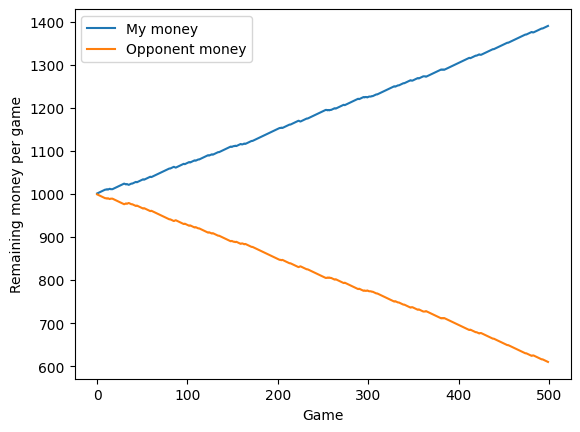

In [85]:
# Create a plot with two lines
plt.plot(my_remaining_money, label='My money')
plt.plot(opponent__remaining_money, label='Opponent money')

# Add labels, title, and legend
plt.xlabel('Game')
plt.ylabel('Remaining money per game')
#plt.title('Plotting Two Lists')
plt.legend()

# Show the plot
plt.show()

#Add new dataset


https://www.kaggle.com/datasets/glushko/rock-paper-scissors-dataset

In [86]:
dataInputPath = '/content/drive/MyDrive/ML_final_data2/train'
paper_imagePathInput = os.path.join(dataInputPath, 'paper/')
rock_imagePathInput = os.path.join(dataInputPath, 'rock/')
scissors_imagePathInput = os.path.join(dataInputPath, 'scissors/')

In [87]:
# Get the list of files in the directory
file_list = os.listdir(dataInputPath)
image_list = []
label_array = []
for i, file in enumerate(file_list):
  imagePathInput = os.path.join(dataInputPath, file)
  print(file)
  image_files = os.listdir(imagePathInput)
  label_array += [i] * len(image_files)
  for image_file in image_files:
    image_path = os.path.join(imagePathInput, image_file)
    image = Image.open(image_path)


    # Define the target dimensions while maintaining the same aspect ratio
    target_width = 32  # Replace with your desired width / original image shape: (200, 300, 3)
    target_height = 21 #int(image.height * (target_width / image.width))

    # Resize the image
    resized_image = image.resize((target_width, target_height), Image.BILINEAR)

    np_img = np.array(resized_image)
    grayscale_image = np.mean(np_img, axis=-1, keepdims=True)
    #grayscale_image = np.reshape(grayscale_image, (21, 32, 1))
    image_list.append(grayscale_image)


scissors
paper
rock


In [88]:
# Use zip to combine the two lists into pairs
combined_data = list(zip(image_list, label_array))

# Shuffle the combined data
random.shuffle(combined_data)

# Use zip again to separate the shuffled pairs back into two lists
image_list, label_array = zip(*combined_data)

In [89]:
# images reshape
image_list = list(image_list)
for i in range(len(image_list)):
  image_list[i] = np.reshape(image_list[i], (21 * 32 * 1))
image_array = np.vstack(image_list)


In [90]:
# data normalization
image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
max_value = np.max(image_array)
min_value = np.min(image_array)
print(max_value)
print(min_value)

1.0
0.0


In [91]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(image_array, label_array, test_size = 0.8, random_state=0)

X_train_flattened = np.array(X_train)
X_test_flattened = np.array(X_test)

# Reshape each flattened image into (21, 32, 1)
X_train_reshaped = X_train_flattened.reshape((X_train_flattened.shape[0], 21, 32, 1))
X_test_reshaped = X_test_flattened.reshape((X_test_flattened.shape[0], 21, 32, 1))

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.convert_to_tensor(X_train_reshaped, dtype=tf.float32)
y_train_one_hot = keras.utils.to_categorical(y_train)
y_train = tf.convert_to_tensor(y_train_one_hot, dtype=tf.int64)

X_test = tf.convert_to_tensor(X_test_reshaped, dtype=tf.float32)
y_test_one_hot = keras.utils.to_categorical(y_test)
y_test = tf.convert_to_tensor(y_test_one_hot, dtype=tf.int64)

In [92]:
my_budget= 1000
opponent_budget = 1000
my_remaining_money = []
opponent__remaining_money = []
games = 500
acc = 0
for i in range(0,games):
  my_budget = my_budget -1
  opponent_budget = opponent_budget -1
  opponent, place = get_opponent_choice() #call the opponent_choice function
  input_image = np.expand_dims(opponent, axis=0)
  predictions = CNN_model.predict(input_image) #make prediction for image class
  predicted_class = np.argmax(predictions) #Get the predicted class

  choices = ["Rock", "Scissor", "Paper"]
  my_choice = None
  opponent_choice = choices[np.argmax(y_test_one_hot[place])]

  if predicted_class == np.argmax(y_test_one_hot[place]): acc +=1 #sum the corect predictions

  if predicted_class == 0:
    #opponent_choice = "Rock"
    my_choice = "Paper"
  elif predicted_class == 1:
    #opponent_choice = "Scissor"
    my_choice = "Rock"
  else:
    #opponent_choice = "Paper"
    my_choice = "Scissor"

  result = compare_choices(opponent_choice, my_choice)

  if result == "You win":
    my_budget += 2
  elif result == "You lose":
    opponent_budget += 2
  else:
    my_budget += 1
    opponent_budget += 1

  my_remaining_money.append(my_budget)
  opponent__remaining_money.append(opponent_budget)

1/1 [==============================] - 0s 22ms/step


In [93]:
print("The prediction accuracy is:", acc/games)

The prediction accuracy is: 0.298


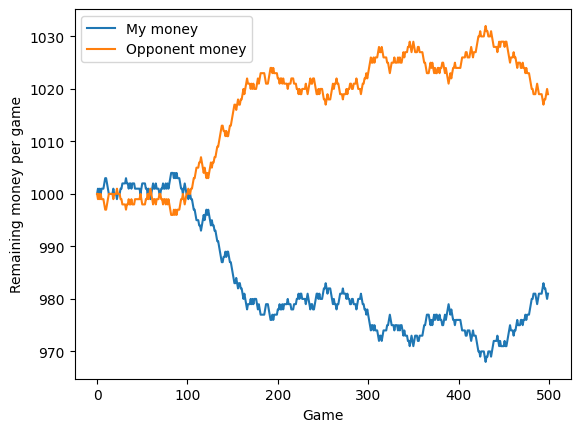

In [94]:
# Create a plot with two lines
plt.plot(my_remaining_money, label='My money')
plt.plot(opponent__remaining_money, label='Opponent money')

# Add labels, title, and legend
plt.xlabel('Game')
plt.ylabel('Remaining money per game')
#plt.title('Plotting Two Lists')
plt.legend()

# Show the plot
plt.show()